In [1]:
import ctypes
import numpy as np
import sounddevice as sd
import soundfile as sf

Real-time speech record noise supression

In [4]:
rnnoise_dll = r"D:\Git_repos\ANC-python\rnnoise.dll"

# Load RNNoise DLL
rnnoise = ctypes.WinDLL(rnnoise_dll)

# Define C prototypes
rnnoise.rnnoise_create.restype = ctypes.c_void_p
rnnoise.rnnoise_destroy.argtypes = [ctypes.c_void_p]
rnnoise.rnnoise_process_frame.argtypes = [
    ctypes.c_void_p,
    np.ctypeslib.ndpointer(dtype=np.float32, ndim=1, flags="C_CONTIGUOUS"),
    np.ctypeslib.ndpointer(dtype=np.float32, ndim=1, flags="C_CONTIGUOUS"),
]

# Create RNNoise state
st = rnnoise.rnnoise_create()

FRAME_SIZE = 480  # 20ms at 48kHz
DURATION = 10  # seconds
SAMPLERATE = 48000

# Buffers
raw_buffer = []
denoised_buffer = []

def callback(indata, outdata, frames, time, status):
    if status:
        print("Status:", status)

    # Take mono input
    chunk = indata[:, 0]

    # Save raw audio
    raw_buffer.append(np.copy(chunk))

    # Ensure frame is correct size
    if len(chunk) < FRAME_SIZE:
        chunk = np.pad(chunk, (0, FRAME_SIZE - len(chunk)))

    # Prepare buffers
    inbuf = np.ascontiguousarray(chunk, dtype=np.float32)
    outbuf = np.zeros(FRAME_SIZE, dtype=np.float32)

    # Run RNNoise in real time
    rnnoise.rnnoise_process_frame(st, outbuf, inbuf)

    # Save denoised
    denoised_buffer.append(outbuf[:frames].copy())

    # Send denoised audio to speakers
    outdata[:, 0] = outbuf[:frames]

# Run real-time stream
print("Running real-time RNNoise for 10s...")
with sd.Stream(channels=1, samplerate=SAMPLERATE,
               blocksize=FRAME_SIZE, dtype="float32",
               callback=callback):
    sd.sleep(DURATION * 1000)

# Convert to arrays
raw_audio = np.concatenate(raw_buffer).astype(np.float32)
denoised_audio = np.concatenate(denoised_buffer).astype(np.float32)

# Save files
sf.write(r"D:\Git_repos\ANC-python\raw.wav", raw_audio, SAMPLERATE)
sf.write(r"D:\Git_repos\ANC-python\denoised.wav", denoised_audio, SAMPLERATE)

print("Saved raw.wav and denoised.wav")

# Clean up
rnnoise.rnnoise_destroy(st)


Running real-time RNNoise for 10s...
Saved raw.wav and denoised.wav


1

file based noise suppression

In [2]:
import ctypes
import numpy as np
import soundfile as sf
import tempfile
import os
from scipy.signal import resample_poly

# Use the .so file from WSL
rnnoise_dll = r"D:\Git_repos\ANC-python\rnnoise_0.dll"

# Load RNNoise shared library
rnnoise = ctypes.CDLL(rnnoise_dll)

# Define C prototypes
rnnoise.rnnoise_create.restype = ctypes.c_void_p
rnnoise.rnnoise_destroy.argtypes = [ctypes.c_void_p]
rnnoise.rnnoise_process_frame.argtypes = [
    ctypes.c_void_p,
    np.ctypeslib.ndpointer(dtype=np.float32, ndim=1, flags="C_CONTIGUOUS"),
    np.ctypeslib.ndpointer(dtype=np.float32, ndim=1, flags="C_CONTIGUOUS"),
]

# Create RNNoise state
st = rnnoise.rnnoise_create()

FRAME_SIZE = 480  # 20ms at 48kHz
TARGET_SR = 48000

# === Load audio file ===
infile = r"C:\Users\User_1\Desktop\noisy_auido_files\noisy_fish.wav"
speech, sr = sf.read(infile, dtype="float32")

# If stereo → take one channel
if speech.ndim > 1:
    speech = speech[:, 0]

tmp_path = None
# Resample if not 48kHz
if sr != TARGET_SR:
    print(f"Resampling {sr}Hz → {TARGET_SR}Hz")
    gcd = np.gcd(sr, TARGET_SR)
    up, down = TARGET_SR // gcd, sr // gcd
    speech = resample_poly(speech, up, down).astype(np.float32)

    # Save to tmp file
    tmp_fd, tmp_path = tempfile.mkstemp(suffix=".wav")
    os.close(tmp_fd)  # we just need the path
    sf.write(tmp_path, speech, TARGET_SR)
    print(f"Temporary 48kHz file created at: {tmp_path}")

    # Reload at 48kHz to be 100% consistent
    speech, sr = sf.read(tmp_path, dtype="float32")

# === Add synthetic noise ===
# Example: 60 Hz hum
t = np.arange(len(speech)) / TARGET_SR
hum = 0.02 * np.sin(2 * np.pi * 60 * t)  # 60 Hz hum
fan = 0.01 * np.random.uniform(-1, 1, len(t))  # low-level fan noise
# noisy = speech + hum + fan
noisy = speech

# === Run RNNoise ===
denoised = np.zeros_like(noisy, dtype=np.float32)
for i in range(0, len(noisy), FRAME_SIZE):
    chunk = noisy[i:i+FRAME_SIZE]
    valid_len = len(chunk)
    if valid_len < FRAME_SIZE:
        chunk = np.pad(chunk, (0, FRAME_SIZE - valid_len))

    inbuf = np.ascontiguousarray(chunk, dtype=np.float32)
    outbuf = np.zeros(FRAME_SIZE, dtype=np.float32)

    rnnoise.rnnoise_process_frame(st, outbuf, inbuf)

    # Copy result
    denoised[i:i+valid_len] = outbuf[:valid_len]

# Save denoised audio
sf.write(r"D:\Git_repos\ANC-python\denoised.wav", denoised, TARGET_SR)
print("Saved denoised.wav")

# Clean up
rnnoise.rnnoise_destroy(st)

if tmp_path and os.path.exists(tmp_path):
    os.remove(tmp_path)
    print(f"Temporary file {tmp_path} deleted.")


Resampling 44100Hz → 48000Hz
Temporary 48kHz file created at: C:\Users\User_1\AppData\Local\Temp\tmpp9w0uyjz.wav
Saved denoised.wav
Temporary file C:\Users\User_1\AppData\Local\Temp\tmpp9w0uyjz.wav deleted.


Spectograms

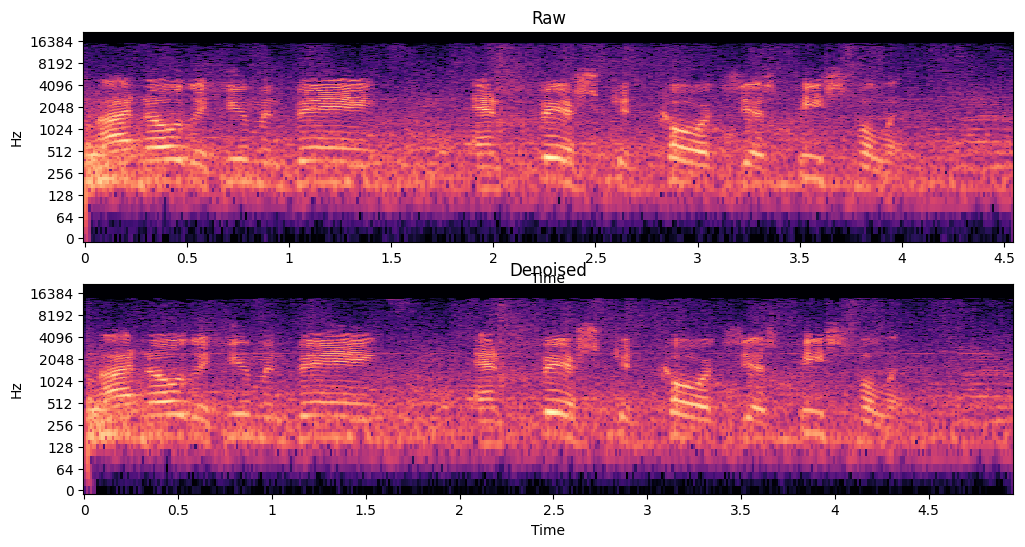

Correlation similarity: 0.0015
SNR after denoising: -3.19 dB
MSE: 0.028760


In [3]:
import matplotlib.pyplot as plt
import librosa, librosa.display

raw_path= r"D:\Git_repos\ANC-python\raw.wav"
raw_path= infile
denoised_path = r"D:\Git_repos\ANC-python\denoised.wav"

raw, sr = librosa.load(raw_path, sr=None)
denoised, _ = librosa.load(denoised_path, sr=None)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(raw)), ref=np.max),
                         sr=sr, x_axis="time", y_axis="log")
plt.title("Raw")

plt.subplot(2,1,2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(denoised)), ref=np.max),
                         sr=sr, x_axis="time", y_axis="log")
plt.title("Denoised")
plt.show()


# ========= Similarity measurement =================
min_len = min(len(raw), len(denoised))
similarity = np.corrcoef(raw[:min_len], denoised[:min_len])[0,1]
print(f"Correlation similarity: {similarity:.4f}")

noise_diff = raw[:min_len] - denoised[:min_len]
snr = 10 * np.log10(np.sum(raw[:min_len]**2) / np.sum(noise_diff**2))
print(f"SNR after denoising: {snr:.2f} dB")

mse = np.mean((raw[:min_len] - denoised[:min_len])**2)
print(f"MSE: {mse:.6f}")



In [14]:
print(noisy.dtype, noisy.min(), noisy.max())


float32 -0.8947754 0.9999695
